##Introduction
A recommendation system is built to predict the most preferred choices of books for a user, based on the book ratings made by the user. Two different recommendation models are presented. Analogous models can be applied to product or service recommendations in a company.


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
%matplotlib inline

###Data

In [4]:
%cd MyDrive/MLData
dataset = pd.read_csv('bookreco/ratings.csv')
dataset.head(10)

/gdrive/MyDrive/MLData


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
5,1,2077,4
6,1,2487,4
7,1,2900,5
8,1,3662,4
9,1,3922,5


**Data contains 10,000 books and 53,424 users, with  mutiple ratings per user and multiple ratings per book.**

In [5]:
print ("Unique values in each column")
nbooks   = 0
nusers   = 0
nratings = 0
for i in dataset.columns:
  unq= np.unique(dataset[i])
  print (i,len(unq))
  if 'book' in i:   nbooks = len(unq)
  if 'user' in i:   nusers = len(unq)
  if 'rating' in i: nratings = len(unq)

print (10*'--',"Null Values")
dataset.isna().any()

Unique values in each column
book_id 10000
user_id 53424
rating 5
-------------------- Null Values


book_id    False
user_id    False
rating     False
dtype: bool



---

**Check Ratings**

Text(0.5, 1.0, 'Ratings')

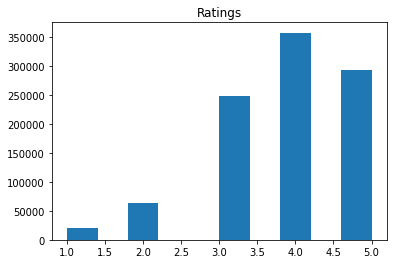

In [6]:
plt.hist(dataset.rating)
plt.title("Ratings")

Ratings are inclined towards higher 3-5 range. 

In [7]:
d2 =dataset.groupby('book_id')
d3 =dataset.groupby('user_id')

Text(0.5, 1.0, 'Mean Users per book')

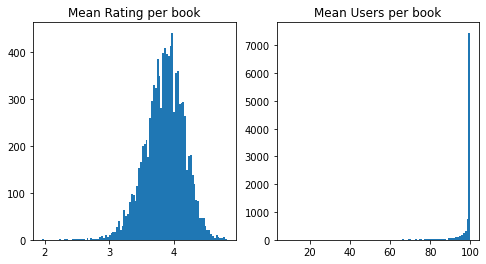

In [8]:
mean_rating_book = d2.aggregate([sum,max,min,np.mean]).iloc[:,7]
num_user_book   = d2.size()
plt.figure(figsize=(8,4))
plt.subplot(121)
ar=plt.hist(mean_rating_book,bins=100)
plt.title("Mean Rating per book")
plt.subplot(122)
ar=plt.hist(num_user_book,bins=100)
plt.title("Mean Users per book")

##Models
The user and book id data are converted into embeddings and the model is trained to predict ratings for  each book, by each user. Two models are tested:
1. Dot product model uses the dot product of the book and user embeddings to predict the rating.
2. Neural Nets model convert user and book embeddings into a fully connected layer, added to few more hidden layers.

###Dot Product Model

In [9]:
# Create embeddings
book_inputs   = tf.keras.Input(shape=(1,))
book_embed    = tf.keras.layers.Embedding(
                input_dim   = nbooks+1,
                output_dim  = 5
    )(book_inputs)
book_vec = Flatten()(book_embed)

user_inputs   = tf.keras.Input(shape=(1,))
user_embed    = tf.keras.layers.Embedding(
              input_dim  = nusers+1,
              output_dim = 5
)(user_inputs)
user_vec = Flatten()(user_embed)

prod  = tf.keras.layers.Dot(axes=1)([book_vec,user_vec])
model = Model([user_inputs,book_inputs],prod)
model.compile('adam','mse')

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 5)         50005       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 5)         267125      ['input_2[0][0]']                
                                                                                              

**Split dataset into test and train subsets**

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=0)
history = model.fit([train.user_id, train.book_id],
          train.rating, 
          epochs=5)

Epoch 1/5
24544/24544 [==============================] - 156s 6ms/step - loss: 13.6102
Epoch 2/5
24544/24544 [==============================] - 133s 5ms/step - loss: 4.2902
Epoch 3/5
24544/24544 [==============================] - 142s 6ms/step - loss: 1.7574
Epoch 4/5
24544/24544 [==============================] - 148s 6ms/step - loss: 1.1903
Epoch 5/5
24544/24544 [==============================] - 153s 6ms/step - loss: 0.9618


**Calculate Loss**

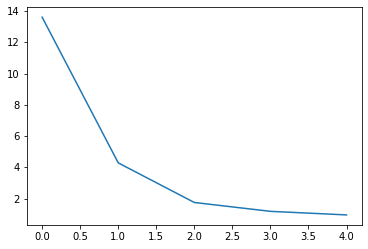

In [12]:
import seaborn as sns 
train_loss= history.history['loss']
#train_acc = history.history['mse']

xepoch = range(0,len(train_loss))
sns.lineplot(x=xepoch,y=train_loss)

###Neural Net Model

In [13]:
# Using Embedding + Neural Nets
from keras.layers import Concatenate

# Create embeddings
book_inputs   = tf.keras.Input(shape=(1,))
book_embed    = tf.keras.layers.Embedding(
                input_dim   = nbooks+1,
                output_dim  = 5
    )(book_inputs)
book_vec = Flatten()(book_embed)

user_inputs   = tf.keras.Input(shape=(1,))
user_embed    = tf.keras.layers.Embedding(
              input_dim  = nusers+1,
              output_dim = 5
)(user_inputs)
user_vec = Flatten()(user_embed)
#Concatenate user and book vecs
conc = Concatenate()([book_vec,user_vec])

#add fully connected layers
fc1 = Dense(units=128,activation='relu')(conc)
fc2 = Dense(units=32,activation='relu')(fc1)
out = Dense(units=1)(fc2)


model2 = Model(inputs=[user_inputs,book_inputs],outputs=out)
model2.compile('adam','mean_squared_error')

In [15]:
historyNN = model2.fit([train.user_id, train.book_id],
          train.rating, 
          epochs=1)


24544/24544 [==============================] - 197s 8ms/step - loss: 0.6519


**Loss**

In [ ]:
train_loss= historyNN.history['loss']

xepoch = range(0,len(train_loss))
sns.lineplot(x=xepoch,y=train_loss)

##Evaluate Model and Predict Ratings

**Dot Product**

In [ ]:
score        = model.evaluate([test.user_id, test.book_id], test.rating)
print("Dot Product Score",score)
ratings_pred = model.predict([test.user_id.head(10), test.book_id.
                             head(10)])


In [ ]:
print ("Rating Prediction")
for i in range(10):
  print ("{:5.1f} {:5.0f}".format(ratings_pred[i,0], test.rating.iloc[i]))

**Neural Net**

In [19]:
score        = model2.evaluate([test.user_id, test.book_id], test.rating)
print("Neural Net",'\n',model2.metrics_names,score)
ratings_pred = model2.predict([test.user_id.head(10), test.book_id.
                             head(10)])
print ("Rating Prediction")
for i in range(10):
  print ("{:5.1f} {:5.0f}".format(ratings_pred[i,0], test.rating.iloc[i]))

6136/6136 [==============================] - 12s 2ms/step - loss: 0.7052
Neural Net 
 ['loss'] 0.705163836479187
Rating Prediction
  3.2     4
  4.6     5
  4.4     5
  4.3     5
  3.1     4
  3.8     3
  4.6     5
  4.7     5
  3.6     3
  4.4     5


##Make Recommendations

In [73]:
#Making Recommendations
book_data      = np.array(list(set(dataset.book_id)))
nb             = len(book_data)
user_test      = np.array(nb*[1])#Get recommendations for User 1 
predict_rating = model.predict([user_test,book_data])

In [75]:
predict_rating = predict_rating.reshape(nb)
args = np.argsort(-predict_rating)[:10]
print ("Best Ratings\n",10*'--')
print ("Rating","  ","Book ID")
for i in args:
  print("{:6.1f}  {:6}".format(predict_rating[i],i))

Best Ratings
 --------------------
Rating    Book ID
   5.6    8945
   4.8    7638
   4.8    7880
   4.7    9079
   4.7    5211
   4.7    9457
   4.7    7498
   4.6    9208
   4.5    7946
   4.5    4777


**Find Book Information from books database**

In [76]:
books = pd.read_csv('bookreco/books.csv')
print (len(books))
print (books.columns)


10000
Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')


**Recommendation for user 1**

In [79]:
reco_books = books.loc[books['id'].isin(args),['id','authors','original_title']]#,['authors','original_title']]
reco_books

,id,authors,original_title
4776,4777,William Faulkner,A Rose for Emily
5210,5211,Catherine Ryan Hyde,Pay It Forward
7497,7498,Jeff Shaara,The Last Full Measure
7637,7638,Iain M. Banks,The Algebraist
7879,7880,Meg Cabot,Princess Mia
7945,7946,Naomi Wolf,The Beauty Myth: How Images of Beauty Are Used...
8944,8945,Lisa Gardner,The Next Accident
9078,9079,Gerald N. Lund,"The Work and the Glory, Vol. 2: Like a Fire Bu..."
9207,9208,Scott McCloud,The Sculptor
9456,9457,"Natsuki Takaya, Alethea Nibley, Athena Nibley",フルーツバスケット 14


##References
1. Based on Book Recommedation System shown [here](https://www.kaggle.com/code/tannergi/book-recommendation-system).